# Path Integral Quantum Statistics

**Objective:** 

Computing the partition function

\begin{equation*}
Z(\beta) = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N U_N(\boldsymbol{x})}d\boldsymbol{x}}
\end{equation*}

where 

\begin{equation*}
U_N(\boldsymbol{x}) = \sum\limits_{n=1}^N \frac{m}{2\beta_N^2\hbar^2}(x_n - x_{n-1})^2 + \sum\limits_{n=1}^N V(x_n)
\end{equation*}
$\boldsymbol{x} = \{x_1, ..., x_N\}$ and $x_0 \equiv x_N$

Choices for V(x):

Morse oscillator
\begin{equation*}
V(x) = D_e(1-e^{-\alpha(x-x_e)})^2
\end{equation*}

First Derivative
\begin{equation*}
\frac{\partial V(x)}{\partial x} = 2D_e \alpha (e^{-\alpha(x-x_e)} - e^{-2\alpha(x-x_e)})
\end{equation*}

Second Derivative
\begin{equation*}
\frac{\partial^2 V(x)}{\partial x^2} = 2D_e \alpha^2 ( 2e^{-2\alpha(x-x_e)}-e^{-\alpha(x-x_e)} )
\end{equation*}

Harmonic oscillator
\begin{equation*}
V_{harm}(x) = \frac{1}{2}m\omega_e^2x^2
\end{equation*}

Second derivative
\begin{equation*}
\frac{\partial^2 V_{harm}(x)}{\partial x^2} = m\omega_e^2
\end{equation*}

Note that at $x=x_e$ the second derivative of the harmonic potential and the second derivative of the Morse potential are the same through the relation $D_e=\hbar\omega_e^2/4\omega_e\chi_e$ and $\alpha = \sqrt{2m\omega_e\chi_e/\hbar}$:

\begin{equation*}
2D_e\alpha^2 = 2\frac{2m\omega_e\chi_e}{\hbar}\frac{\hbar\omega_e^2}{4\omega_e\chi_e} = m\omega_e^2
\end{equation*}

In [25]:
import numpy as np
import scipy
from scipy.constants import physical_constants, c, h, hbar, Boltzmann
from scipy.stats import norm
from scipy.integrate import dblquad
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns

set_matplotlib_formats('png', 'pdf')
%matplotlib inline

def make_color(NUM_COLORS, palette='husl', cubehelix=False):
    sns.reset_orig()  # get default matplotlib styles back
    clrs = sns.color_palette(palette, n_colors=NUM_COLORS) 
    if cubehelix:
        clrs = sns.cubehelix_palette(n_colors=NUM_COLORS, start=2.8, rot=.1)
    return clrs

#everything in SI units
u = physical_constants['atomic mass constant'][0]
inv_cm = 2*np.pi*c # * hbar * 100 
we = 3737.76*inv_cm
wexe = 84.881*inv_cm 
m = 16/17*u #reduced mass
De = (hbar*we**2)/(4*wexe)
xe = 0.96966e-10
alpha = np.sqrt((2*m*wexe)/hbar)
T = 298

In [6]:
def V(x, De=De, alpha=alpha, xe=xe):
    """Morse oscillator"""
    return De*(1-np.exp(-alpha*(x-xe)))**2

def d2Vdx2(x, De=De, alpha=alpha, xe=xe):
    """second derivative of Morse oscillator"""
    tmp = 2*np.exp(-alpha*(x-xe))
    return De*alpha**2*tmp*(tmp-1)

def Q(x, m=m, T=T, De=De, alpha=alpha, xe=xe, pot=V):
    """ring polymer potential"""
    N = x.shape[0]
    betaN = 1/(N*Boltzmann*T)
    k = m/(betaN**2*hbar**2)
    return 0.5*k*np.sum((x-np.roll(x,1))**2) + np.sum(pot(x, De=De, alpha=alpha, xe=xe))

def Qsep(x, m=m, T=T, De=De, alpha=alpha, xe=xe, pot=V):
    """ring polymer potential with separated variables"""
    N = x.shape[0]
    betaN = 1/(N*Boltzmann*T)
    k = m/(betaN**2*hbar**2)
    return 0.5*k*(x-np.roll(x,1))**2 + pot(x, De=De, alpha=alpha, xe=xe)



def Vharm(x, m=m, we=we):
    """Harmonic potential"""
    return (1/2) * m * we**2 * x**2

def ddVharm(x):
    """Second derivative of Vharm"""
    return m * omega**2

# Construction of Ring-Polymer Hessian

Derivatives of $U_N(x)$

First derivative
\begin{equation*}
\frac{\partial U_N(x)}{\partial x_i} = \frac{\partial}{\partial x_i} \frac{m}{2\beta_N^2\hbar^2}((x_1-x_{N-1})^2 + (x_2-x_1)^2 + ... + (x_N-x_{N-1})^2) + \frac{\partial}{\partial x_i} V(x_i) 
\end{equation*}
\begin{equation*}
= \frac{m}{2\beta_N^2\hbar^2} (4x_i -2x_{i+1}-2x_{i-1})+ \frac{\partial}{\partial x_i} V(x_i) 
\end{equation*}
\begin{equation*}
= \frac{m}{\beta_N^2\hbar^2} (2x_i-x_{i+1}-x_{i-1}) +\frac{\partial}{\partial x_i} V(x_i)
\end{equation*}

Second derivative, which generates the entries of the Hessian $H$
\begin{equation*}
H_{i,j} = \nabla^2U_N(\boldsymbol x)= \frac{m}{\beta_N^2\hbar^2}  (2\delta_{i,j}-\delta_{i+1,j}-\delta_{i-1,j}) + \delta_{i,j}\frac{\partial^2V(x_i)}{\partial x_i^2}
\end{equation*}


The $N\times N$ Hessian is thus:
\begin{equation*}
H=\frac{m}{\beta_N^2\hbar^2}
\begin{pmatrix}
C_1 & -1 & 0 & \cdots & \cdots &0 & -1 \\
-1 & C_2 & -1 & 0 &  &  & 0  \\
0 & -1 & C_3 & -1 & 0 &   & \vdots \\
\vdots &  & \ddots & \ddots & \ddots & & \vdots \\
\vdots & & & \ddots & \ddots & \ddots  & 0 \\
0 &  & &  & -1 & C_{N-1} & -1 \\
-1 & 0 & \cdots & \cdots & 0 & -1 & C_N
\end{pmatrix}
\end{equation*}

where $$C_i = 2 + \frac{\beta_N^2\hbar^2}{m} \frac{\partial^2V(x_i)}{\partial x_i^2}$$



For a ring-polymer collapsed at the bottom of the potential $\boldsymbol{x}=\{x_e, \cdots, x_e\}$ and $V(x) = 0$

In [3]:
def RPHessian(x, m=m, T=T, De=De, alpha=alpha, xe=xe):
    N = x.shape[0]
    betaN = 1/(N*Boltzmann*T)
    k = m/(betaN**2*hbar**2)
    diagonal = 2 + (1/k) * d2Vdx2(x, De=De, alpha=alpha, xe=xe) 
    if N == 1:
        hessian = np.array(diagonal) * k
    elif N == 2:
        hessian = scipy.sparse.diags([[-1], diagonal, [-1]],[-1,0,1], shape=(N,N)).toarray() * k
    else:
        hessian = scipy.sparse.diags([[-1], [-1], diagonal, [-1], [-1]],[-(N-1),-1,0,1,N-1], shape=(N,N)).toarray() * k
    return hessian

In [7]:
N = 8
x = np.zeros(N)

#a)
H = RPHessian(x)
print("a) Hessian\n",H,"\n")

# diagonalise Hessian and test if Uᵀ H U is a diagonal Matrix with eigenvalues along the diagonal
evals, U = np.linalg.eigh(H)
M = U.T@H@U
print("b) U.T@H@U\n", M,
    "\nnumerical error (compared to true diagonal matrix):", np.linalg.norm(M-np.diag(evals)),"\n")

a) Hessian
 [[ 304.63336268 -152.24635511    0.            0.            0.
     0.            0.         -152.24635511]
 [-152.24635511  304.63336268 -152.24635511    0.            0.
     0.            0.            0.        ]
 [   0.         -152.24635511  304.63336268 -152.24635511    0.
     0.            0.            0.        ]
 [   0.            0.         -152.24635511  304.63336268 -152.24635511
     0.            0.            0.        ]
 [   0.            0.            0.         -152.24635511  304.63336268
  -152.24635511    0.            0.        ]
 [   0.            0.            0.            0.         -152.24635511
   304.63336268 -152.24635511    0.        ]
 [   0.            0.            0.            0.            0.
  -152.24635511  304.63336268 -152.24635511]
 [-152.24635511    0.            0.            0.            0.
     0.         -152.24635511  304.63336268]] 

b) U.T@H@U
 [[ 1.40652472e-01  1.05899728e-14  4.84823695e-14  8.18553395e-14
  -4.821868

# Normal Modes and Diagonalisation of Hessian

$U_N(x)$ can be expanded as a Taylor series:

\begin{equation*}
U_N(\boldsymbol{x})=\frac{1}{2} \boldsymbol{x}^T \boldsymbol{Hx}+\cdots=\frac{1}{2} \sum\limits_{i=1}^N\sum\limits_{j=1}^N x_iH_{ij}x_j
\end{equation*}

where $H_{ij}$ is the element in the i-th row and j-th column of the Hessian of a ring-polymer of size N collapsed at the bottom of the potential. By transforming into a normal mode basis, coupling terms of the form $(x_i-x_j)^2$ and thus the off-diagonal elements of the Hessian $\boldsymbol{H}$ can be eliminated, thus also eliminating multidimensional integrals in the partition function:

\begin{equation*}
\boldsymbol{H'=U^THU}
\end{equation*}
where $\boldsymbol{H'}$ is the diagonalised Hessian with the eigenvalues $\lambda_i$ of $\boldsymbol{H}$ along the diagonal and $\boldsymbol{U}$ is the transformation matrix with the eigenvectors in the columns. With $\boldsymbol{q}=\boldsymbol{U^T}(\boldsymbol{x}-x_e)$ this gives ($\rightarrow$ problem 1 c):

\begin{equation*}
U_N(\boldsymbol{x})=\frac{1}{2} \boldsymbol{x}^T \boldsymbol{Hx}+\cdots=\frac{1}{2} \sum\limits_{i=1}^N\sum\limits_{j=1}^N x_iH_{ij}x_j = \frac{1}{2} \boldsymbol{q}^T \boldsymbol{H'q}+\cdots=\frac{1}{2} \sum\limits_{i=1}^N\sum\limits_{j=1}^N q_iH'_{ij}q_j = \frac{1}{2} \sum\limits_{i=1}^N \lambda_iq_i^2
\end{equation*}

\begin{equation*}
\Rightarrow \boldsymbol{x}^T \boldsymbol{Hx} = \sum\limits_{i} \lambda_iq_i^2
\end{equation*}


In [5]:
# Test if above relation is true for random path-integral configuration x

Ntrials = 10
for i in range(Ntrials):
    N = np.random.randint(2,20)
    x = np.random.uniform(low=0,high=3,size=(N))
    H = RPHessian(xe*np.ones(N))
    lam, U = np.linalg.eigh(H)
    q = U.T@(x-xe) 
    tmp1 = (x-xe).T@H@(x-xe)
    tmp2 = np.sum(lam*q**2)
    print("N", N, "x.T@H@x", tmp1 , "sum_k(lam_k*q_k**2)", tmp2, "error", np.abs(tmp1-tmp2))

N 9 x.T@H@x 5344.69354703709 sum_k(lam_k*q_k**2) 5344.693547037095 error 5.4569682106375694e-12
N 17 x.T@H@x 13120.892903690292 sum_k(lam_k*q_k**2) 13120.892903690241 error 5.093170329928398e-11
N 9 x.T@H@x 848.4108948895613 sum_k(lam_k*q_k**2) 848.4108948895597 error 1.5916157281026244e-12
N 3 x.T@H@x 26.561368560307248 sum_k(lam_k*q_k**2) 26.56136856030725 error 3.552713678800501e-15
N 4 x.T@H@x 261.10393237717693 sum_k(lam_k*q_k**2) 261.103932377177 error 5.684341886080802e-14
N 3 x.T@H@x 115.53778760273599 sum_k(lam_k*q_k**2) 115.53778760273596 error 2.842170943040401e-14
N 19 x.T@H@x 39524.72789075172 sum_k(lam_k*q_k**2) 39524.7278907517 error 1.4551915228366852e-11
N 18 x.T@H@x 26117.05963429721 sum_k(lam_k*q_k**2) 26117.059634297173 error 3.637978807091713e-11
N 18 x.T@H@x 22634.70569499179 sum_k(lam_k*q_k**2) 22634.705694991742 error 4.729372449219227e-11
N 8 x.T@H@x 1990.60121685257 sum_k(lam_k*q_k**2) 1990.6012168525697 error 2.2737367544323206e-13


# Monte Carlo Importance Sampling
## Separating the integration variables
The partition function
\begin{equation*}
Z(\beta) = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N U_N(\boldsymbol{x})}d\boldsymbol{x}}
\end{equation*}
can be computed by Monte Carlo Importance Sampling

With a Taylor expansion to second order of the diagonalised Hessian (harmonic approximation) the multidimensional integral in the partition function can be expressed as a product of one-dimensional integrals:

\begin{equation*}
Z(\beta) = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N U_N(\boldsymbol{x})}d\boldsymbol{x}} = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N \frac{1}{2} \boldsymbol{x}^T \boldsymbol{Hx}}} = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N \frac{1}{2} \sum\limits_{n=1}^N \lambda_nq_n^2}} 
\end{equation*}
\begin{equation*}
\\=
\Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N \frac{1}{2} \sum\limits_{n=1}^N \omega_n^2q_n^2}} = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N \frac{1}{2} \omega_1^2q_1^2}}\int\cdots\int{e^{-\beta_N \frac{1}{2} \omega_N^2q_N^2}}
\end{equation*}

where the relation between the eigenvalues $\lambda_i$ and eigenfrequencies $\omega_n$ is used: $\lambda_n=\omega_n^2$ and $\omega_n^2 = \frac{4}{\beta_N^2\hbar^2}\sin^2{\frac{|n|\pi}{N}}+\omega_e^2$

More generally for a potential $V(q_i)$ only depending on one variable:
\begin{equation*}
Z(\beta) = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N \sum\limits_{i=1}^N V(\boldsymbol{q})}} = \Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \int{e^{-\beta_N V(q_1)}}\int\cdots\int{e^{-\beta_N V(q_N)}}
\end{equation*}



## Importance sampling
\begin{equation*}
I = \int{e^{-\beta_N V(q_n)}} \approx \frac{1}{K} \sum\limits_{k=1}^K \frac{e^{-\beta_N V((q_n)_k)}}{\sqrt{\frac{\beta_N\lambda_n}{2\pi}}e^{-\beta_N\lambda_n (q_n)_k^2 /2}} = \Big\langle e^{-\beta_N V(q_n)}\Big\rangle
\end{equation*}

Where $K$ samples of $q_n$ are sampled from the  distribution
\begin{equation*}
q_n\sim\sqrt{\frac{\beta_N\lambda_n}{2\pi}}e^{-\beta_N\lambda_n q_n^2/2}
\end{equation*}

This corresponds to a normal distribution of $q_n$ with $\sigma^2=\frac{1}{\beta_N\lambda_n}$ and $\mu=0$

The statistical error $\sigma$ is estimated as: 
\begin{equation*}
\sigma^2=\frac{\langle f^2(q)\rangle -\langle f(q)\rangle^2}{K-1}=\frac{1}{K-1}\Bigl[\frac{1}{K}\sum\limits_{k=1}^K \frac{f^2(q_k)}{g^2(q_k)} - \Bigl(\sum\limits_{k=1}^K \frac{1}{K} \frac{f(q_k)}{g(q_k)}\Bigr)^2\Bigr]
\end{equation*}

$K$ is the number of samples

$g(q)$ is the importance sampling distribution: $g((q_n)_k) = \sqrt{\frac{\beta_N\lambda_n}{2\pi}}e^{-\beta_N\lambda_n (q_n)_k^2/2}$

$f(q)$ is function over which is integrated: $f(q) = e^{-\beta_N V(q)}$

The partition function of the harmonic oscillator of a ring-polymer with $N$ beads, computed by Monte Carlo Importance sampling with $K$ samples is:

\begin{equation*}
Z(\beta)\approx\Bigl(\frac{m}{2\pi\beta_N\hbar^2}\Bigr)^{N/2} \prod\limits_{n=1}^N \Big\langle e^{-\beta_N V(q_n)}\Big\rangle 
\end{equation*}



In [26]:
def MCimportance(N, steps=100, T=T, m=m, De=De, alpha=alpha, xe=xe):
    """Computes partition function of ring-polymer with N beads by Monte Carlo importance sampling"""
    betaN = 1/(N*Boltzmann*T)
    A = (m / (2*np.pi*betaN*hbar**2))**(1/2)
    ssep = 0
    sharm = 0
    altsharm = 0
    errSqr = 0
    sep = np.zeros(N)
    x = xe * np.ones(N)
    H = RPHessian(x, m=m, T=T, De=De, alpha=alpha, xe=xe)
    if x.shape[0] > 1:
        lam, U = np.linalg.eigh(H)
    else:
        lam, U = H, np.ones(1)
    mu = np.zeros(N)
    sigma = np.sqrt(1/(betaN*lam))
    dist = scipy.stats.norm(loc=mu, scale=sigma)
    for i in range(steps):
        dist = scipy.stats.norm(loc=mu, scale=sigma)
        q = dist.rvs()
        x = U@q + xe
        Zsep = np.prod((A*np.exp(-betaN*Qsep(x, m=m, T=T, De=De, alpha=alpha, xe=xe))) / dist.pdf(q))
        ssep += Zsep
        Zharm = np.prod((A*np.exp(-betaN*0.5*lam * q**2))/ dist.pdf(q)) # np.exp(-betaN*np.sum(0.5*lam * q**2))
        sep += np.exp(-betaN*0.5*lam * q**2) / dist.pdf(q)
        sharm += Zharm # / np.prod(dist.pdf(q))
        errSqr += Zsep**2
    variance = (1/(steps-1)) * ((errSqr/steps) - ((1/steps)*ssep)**2)
    return (1/steps)*ssep,  (1/steps) * sharm, np.sqrt(variance)

Q, Qharm, error = MCimportance(32, steps=10000)

print('Partition function at 298 K: \n anharmonic {} ± {} \n harmonic {}'.format(Q, error, Qharm))

Partition function at 298 K: 
 anharmonic 14.404842211377698 ± 7.90362334800269 
 harmonic 5.533791863679248


Text(0.5, 0, 'Size of Ring-Polymer N')

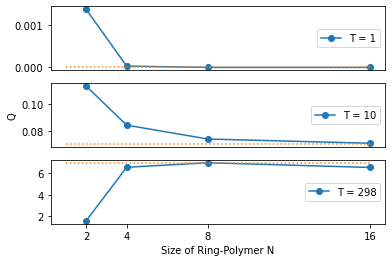

In [187]:


# Convergence of Monte Carlo Sampling of differently sized ring-polymers at different beta
Tlist = np.array([1, 10, 298]) # temperatures
betalist = 1/(Boltzmann*Tlist)
RPsizelist = [2, 4, 8, 16]

fig, ax = plt.subplots(len(betalist))

for i in range(len(betalist)):
    y = [MCimportance(RPsize, T=Tlist[i], steps=10000)[0] for RPsize in RPsizelist]
    ax[i].plot(RPsizelist, y, '-o', label=r'T = '+str(Tlist[i]))
    ax[i].plot([1, 16], [QMpartition(nmax, T=Tlist[i], energyFunc=MorseEnergy)]*2, ':')
    ax[i].legend(loc="center right")
    ax[i].set_xticks([])
ax[1].set_ylabel('Q')
ax[-1].set_xticks(RPsizelist)
plt.xlabel('Size of Ring-Polymer N')

# Quantum Mechanical Partition Function

The quantum partition function is the trace of the Boltzmann operator, which is the same as the sum of the exponential of the energy levels $E_i$ (eigenvalues of Hamiltonian):
\begin{equation*}
Q(\beta) = tr\big[e^{-\beta\hat{H}}\big] = \sum\limits_n e^{-\beta E_n}
\end{equation*}

For the harmonic oscillator and the Morse oscillator, the Schrödinger equation can be solved analytically and the energy levels can be computed:

Harmonic oscillator: 
\begin{equation*}
E_n = h \omega_e \Big(1 + \frac{1}{2} n\Big)
\end{equation*}

Morse oscillator (valid for $n\leq n_{max} = \frac{2D_e-h\omega_0}{h \omega_0}=21$):

\begin{equation*}
E_n = hc \Bigg[\omega_e  \Big(1 + \frac{1}{2} n\Big) - \omega_e\chi_e \Big(1 + \frac{1}{2}n\Big)^2\Bigg] = h\omega_0\Big(1 + \frac{1}{2}n\Big) - \frac{h^2 \omega_0^2}{4D_e}\Big(1 + \frac{1}{2}n\Big)^2
\end{equation*}

where $\omega_0 = \frac{\alpha}{2\pi} \sqrt{\frac{2D_e}{m}}$

In [22]:
def MorseEnergy(n, we=we, wexe=wexe, m=m):
    """Energy levels of Morse oscillator"""
    omega0 = (alpha / (2 * np.pi)) * np.sqrt((2*De)/m)
    return h * omega0 * (n + (1/2)) - ((h**2 * omega0**2)/(4*De)) * (n + (1/2))**2

def harmonicEnergy(n, we=we):
    """Energy levels of harmonic oscillator"""
    return hbar*we*(n + (1/2))

def QMpartition(steps, T=T, energyFunc=MorseEnergy):
    """Quantum partition function"""
    beta = 1/(Boltzmann*T)
    s = 0
    for n in range(steps):
        s += np.exp(-beta*energyFunc(n))
    return s


omega0 = (alpha / (2 * np.pi)) * np.sqrt((2*De)/m)
nmax = int((2*De - h*omega0) / (h*omega0))

ZQM = QMpartition(nmax, T=298)
ZQMharm = QMpartition(100, T=298, energyFunc=harmonicEnergy)

print("Quantum mechanical partition function at 298 K \n anharmonic {} \n harmonic {}".format(ZQM, ZQMharm))

Quantum mechanical partition function at 298 K 
 anharmonic 6.942455454296371 
 harmonic 5.533784430277623


# Classical Partition Function with Quadrature
The classical partition function is:

\begin{equation*}
Z=\frac{1}{h} \int e^{-\beta H(p,q)} dpdq
\end{equation*}

where $H(p, q)$ is the Hamiltonian:
\begin{equation*}
H(p, q) = \frac{p^2}{2m} + V(q)
\end{equation*}

$V(q)$ is either the Morse potential or the harmonic potential. The Morse potential is truncated when $|V(x) - D_e| < 0.05 D_e$. 

In [20]:
def Hamiltonian(p, q, m=m, T=T, De=De, alpha=alpha, xe=xe):
    """Classical Hamiltonian"""
    beta = 1/(Boltzmann*T)
    return p**2/(2*m) + V(q, De=De, alpha=alpha, xe=xe)

def HamiltonianH(p, q, m=m, we=we):
    """Classical Hamiltonian (harmonic)"""
    beta = 1/(Boltzmann*T)
    return p**2/(2*m) + Vharm(q, m=m, we=we)

def classicalZ(p, q, T=T, m=m, De=De, alpha=alpha, xe=xe):
    """Classical partition function (anharmonic)"""
    beta = 1/(Boltzmann*T)
    return np.exp(-beta*Hamiltonian(p, q, m=m, T=T, De=De, alpha=alpha, xe=xe))

def classicalZH(p, q, T=T, m=m,  we=we):
    """Classical partition function (harmonic)"""
    beta = 1/(Boltzmann*T)
    return np.exp(-beta*HamiltonianH(p, q, m=m, we=we))

def classicalQuad(T=T, m=m, we=we):
    expLim = 746
    plimit = np.sqrt(expLim * 2 * m * Boltzmann * T) 
    qlimit = np.sqrt(expLim * 2 * Boltzmann * T * (1/(m * we**2)))
    f = lambda p, q: classicalZ(p, q, T=T, m=m, De=De, alpha=alpha, xe=xe)
    return (1/h) * dblquad(f, 0, 19e-10, lambda x: -plimit, lambda x: plimit)[0]

def classicalQuadH(T=T, m=m, we=we):
    expLim = 746
    plimit = np.sqrt(expLim * 2 * m * Boltzmann * T) 
    qlimit = np.sqrt(expLim * 2 * Boltzmann * T * (1/(m * we**2)))
    f = lambda p, q: classicalZH(p, q, T=T, m=m, we=we)
    return (1/h) * dblquad(f, -qlimit, qlimit, lambda x: -plimit, lambda x: plimit)[0]
    
T=10
# the integral boundaries are selected as the first x for which np.exp(-x) = 0, in this case np.exp(-746)=0
expLim = 746
plimit = np.sqrt(expLim * 2 * m * Boltzmann * T) 
qlimit = np.sqrt(expLim * 2 * Boltzmann * T * (1/(m * we**2)))

ZQuad = (1/h) * dblquad(classicalZ, 0, 19e-10, lambda x: -plimit, lambda x: plimit)[0]
ZQuadH = (1/h) * dblquad(classicalZH, -qlimit, qlimit, lambda x: -plimit, lambda x: plimit)[0]

print("Classical partition function at 298 K \n anharmonic {} \n harmonic {}".format(ZQuad, ZQuadH))

Classical partition function at 298 K 
 anharmonic 0.18680873796205097 
 harmonic 0.18599631108949405


# Conclusion

Text(0, 0.5, '$Z(\\beta)$')

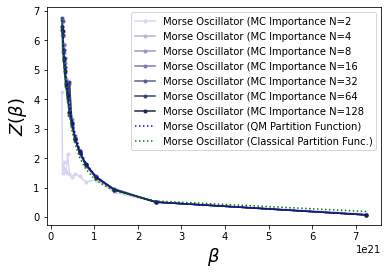

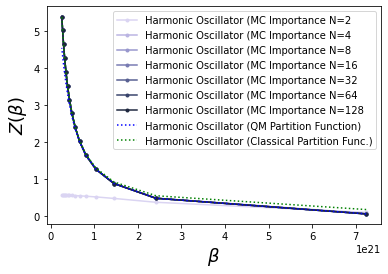

In [188]:
Tlist = np.arange(10, 310, 20) 
Nlist = [2, 4, 8, 16, 32, 64, 128]
ZQM = [QMpartition(nmax, T=T_i, energyFunc=MorseEnergy) for T_i in Tlist]
ZQMharm = [QMpartition(10, T=T_i, energyFunc=harmonicEnergy) for T_i in Tlist]

ZClass = [classicalQuad(T=T_i) for T_i in Tlist]
ZClassH = [classicalQuadH(T=T_i) for T_i in Tlist]
colors = make_color(len(Nlist), cubehelix=True)

beta = 1/(Boltzmann * Tlist)

fig, ax = plt.subplots()
for n in range(len(Nlist)):
    MCI = [MCimportance(Nlist[n], steps=1000, T=T_i) for T_i in Tlist]
    MCIanh = [M[0] for M in MCI]
    MCIharm = [M[1] for M in MCI]
    ax.plot(beta, MCIanh, marker='.', color=colors[n], label='Morse Oscillator (MC Importance N={})'.format(Nlist[n]))
ax.plot(beta, ZQM, ':b', label='Morse Oscillator (QM Partition Function)' )
ax.plot(beta, ZClass, ':g', label='Morse Oscillator (Classical Partition Func.)')
ax.legend()
ax.set_xlabel(r'$\beta$', fontsize=18)
ax.set_ylabel(r'$Z(\beta)$', fontsize=18)

fig, ax = plt.subplots()
for n in range(len(Nlist)):
    MCI = [MCimportance(Nlist[n], steps=2, T=T_i) for T_i in Tlist]
    MCIanh = [M[0] for M in MCI]
    MCIharm = [M[1] for M in MCI]
    ax.plot(beta, MCIharm, marker='.', color=colors[n],label='Harmonic Oscillator (MC Importance N={})'.format(Nlist[n]))
ax.plot(beta, ZQMharm, ':b', label='Harmonic Oscillator (QM Partition Function)')
ax.plot(beta, ZClassH, ':g', label='Harmonic Oscillator (Classical Partition Func.)')
ax.legend()
ax.set_xlabel(r'$\beta$', fontsize=18)
ax.set_ylabel(r'$Z(\beta)$', fontsize=18)